# 🎲 Simulation Basics - How the System Evolves

Learn how the discrete event simulation works:
- **Customer arrivals**: Random timing and demand
- **Order arrivals**: Random lead times
- **Net inventory updates**: Becomes negative when stockout
- **SimPy**: Process-based simulation framework

**Key**: Understand the stochastic dynamics!

**Note**: We use SimPy (Simulation in Python) - the industry standard for discrete event simulation. But don't worry, you don't need to know SimPy internals - just understand the concepts!

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: System Parameters

From the assignment specification:

In [2]:
from src.simulation import SystemParameters

params = SystemParameters.create_default()

print("System Parameters:")
print(f"\nCustomer Arrivals:")
print(f"  Rate (λ): {params.lambda_arrival} customers/day")
print(f"  Mean inter-arrival: {1/params.lambda_arrival:.1f} days")

print(f"\nProduct 0 Demand:")
print(f"  Values: {params.demand_0_values}")
print(f"  Probs: {params.demand_0_probs}")
mean_demand_0 = sum(v*p for v, p in zip(params.demand_0_values, params.demand_0_probs))
print(f"  Mean: {mean_demand_0:.2f} units/customer")

print(f"\nProduct 1 Demand:")
print(f"  Values: {params.demand_1_values}")
print(f"  Probs: {params.demand_1_probs}")
mean_demand_1 = sum(v*p for v, p in zip(params.demand_1_values, params.demand_1_probs))
print(f"  Mean: {mean_demand_1:.2f} units/customer")

print(f"\nLead Times:")
print(f"  Product 0: Uniform({params.lead_time_0_min}, {params.lead_time_0_max}) days")
print(f"  Product 1: Uniform({params.lead_time_1_min}, {params.lead_time_1_max}) days")

print(f"\n💡 Key insights:")
print(f"   - Product 1 has higher demand ({mean_demand_1:.1f} vs {mean_demand_0:.1f})")
print(f"   - Product 1 has faster delivery ({params.lead_time_1_max:.1f} vs {params.lead_time_0_max:.1f})")
print(f"   - Customers arrive ~every 10 days on average")

System Parameters:

Customer Arrivals:
  Rate (λ): 0.1 customers/day
  Mean inter-arrival: 10.0 days

Product 0 Demand:
  Values: (1, 2, 3, 4)
  Probs: (0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666)
  Mean: 2.50 units/customer

Product 1 Demand:
  Values: (5, 4, 3, 2)
  Probs: (0.125, 0.5, 0.25, 0.125)
  Mean: 3.62 units/customer

Lead Times:
  Product 0: Uniform(0.5, 1.0) days
  Product 1: Uniform(0.2, 0.7) days

💡 Key insights:
   - Product 1 has higher demand (3.6 vs 2.5)
   - Product 1 has faster delivery (0.7 vs 1.0)
   - Customers arrive ~every 10 days on average


### Visualize Demand Distributions

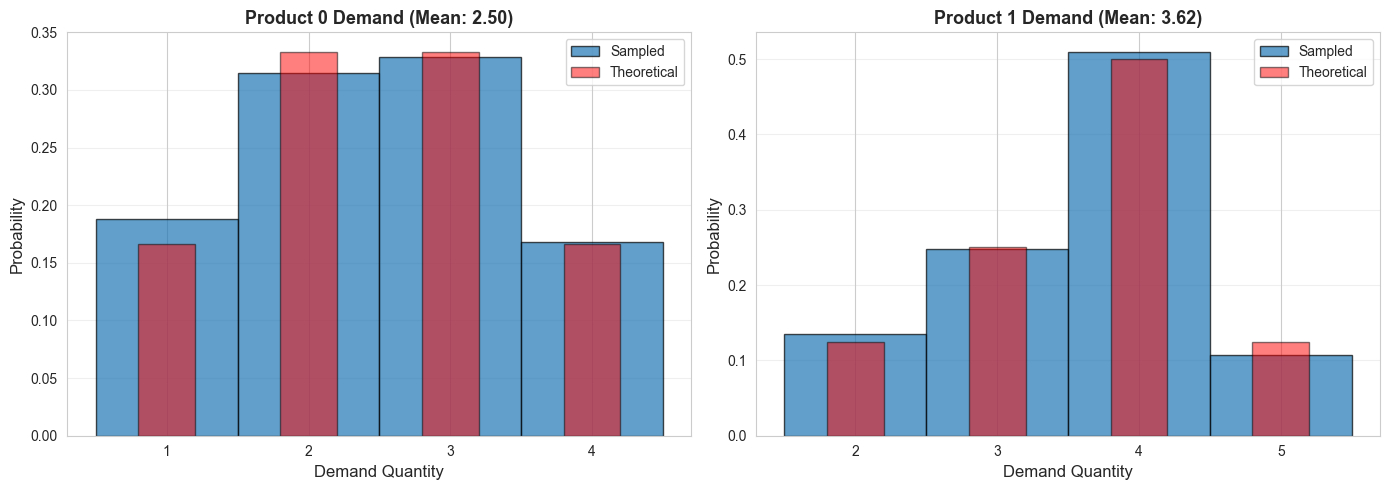

In [3]:
# Sample demand many times
rng = np.random.default_rng(42)
n_samples = 1000

demands_0 = rng.choice(params.demand_0_values, size=n_samples, p=params.demand_0_probs)
demands_1 = rng.choice(params.demand_1_values, size=n_samples, p=params.demand_1_probs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Product 0
axes[0].hist(demands_0, bins=np.arange(0.5, 5.5, 1), density=True, 
             alpha=0.7, edgecolor='black', label='Sampled')
axes[0].bar(params.demand_0_values, params.demand_0_probs, 
            alpha=0.5, color='red', edgecolor='black', width=0.4, label='Theoretical')
axes[0].set_xlabel('Demand Quantity', fontsize=12)
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_title(f'Product 0 Demand (Mean: {mean_demand_0:.2f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].set_xticks(params.demand_0_values)
axes[0].grid(True, alpha=0.3, axis='y')

# Product 1
axes[1].hist(demands_1, bins=np.arange(1.5, 6.5, 1), density=True,
             alpha=0.7, edgecolor='black', label='Sampled')
axes[1].bar(params.demand_1_values, params.demand_1_probs,
            alpha=0.5, color='red', edgecolor='black', width=0.4, label='Theoretical')
axes[1].set_xlabel('Demand Quantity', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title(f'Product 1 Demand (Mean: {mean_demand_1:.2f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(params.demand_1_values)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 2: Run Simple Simulation

In [4]:
from src.simulation import InventorySimulation
from src.mdp import create_observation, order_both_products

# Create simulation
sim = InventorySimulation(params, rng)

# Initial state
initial_obs = create_observation(50, 50, 0, 0)
sim.reset(initial_obs)

print("Initial Observation:")
print(f"  Net inventory: {initial_obs.net_inventory}")
print(f"  Outstanding: {initial_obs.outstanding_orders}")

# Take action: order 10 units of each
action = order_both_products(10, 10)
print(f"\nAction: Order {action.order_quantities}")

# Simulate one day
next_obs, info = sim.execute_daily_decision(action)

print(f"\nAfter 1 day:")
print(f"  Net inventory: {next_obs.net_inventory}")
print(f"  Outstanding: {next_obs.outstanding_orders}")
print(f"\n  Events:")
print(f"    Customers: {info['num_customers']}")
print(f"    Total demand: {info['total_demand']}")
print(f"    Order arrivals: {info['num_order_arrivals']}")

print(f"\n💡 What happened:")
print(f"   1. We ordered (10, 10) → outstanding increased")
print(f"   2. {info['num_customers']} customers arrived")
print(f"   3. They demanded {info['total_demand']} units")
print(f"   4. Net inventory decreased by demand")
if next_obs.outstanding_orders != (10, 10):
    print(f"   5. Some orders arrived (fast lead time!)")
else:
    print(f"   5. Orders still in-transit (not arrived yet)")

Initial Observation:
  Net inventory: (50, 50)
  Outstanding: (0, 0)

Action: Order (10, 10)

After 1 day:
  Net inventory: (60, 60)
  Outstanding: (0, 0)

  Events:
    Customers: 0
    Total demand: (0, 0)
    Order arrivals: (1, 1)

💡 What happened:
   1. We ordered (10, 10) → outstanding increased
   2. 0 customers arrived
   3. They demanded (0, 0) units
   4. Net inventory decreased by demand
   5. Some orders arrived (fast lead time!)


## Part 3: Multi-Day Simulation

Let's see how the system evolves over 20 days with a simple policy.

In [5]:
# Reset simulation
sim = InventorySimulation(params, np.random.default_rng(123))
sim.reset(create_observation(50, 50, 0, 0))


# Simple policy: order 10 units if inventory position < 40
def simple_policy(obs):
    pos_0 = obs.get_inventory_position(0)
    pos_1 = obs.get_inventory_position(1)

    q0 = 10 if pos_0 < 40 else 0
    q1 = 10 if pos_1 < 40 else 0

    return order_both_products(q0, q1)


# Run simulation
history = []
current_obs = create_observation(50, 50, 0, 0)

for day in range(20):
    # Policy decision
    action = simple_policy(current_obs)

    # Execute
    next_obs, info = sim.execute_daily_decision(action)

    # Record
    history.append(
        {
            "day": day,
            "net_inv_0": next_obs.net_inventory[0],
            "net_inv_1": next_obs.net_inventory[1],
            "outstanding_0": next_obs.outstanding_orders[0],
            "outstanding_1": next_obs.outstanding_orders[1],
            "customers": info["num_customers"],
            "demand_0": info["total_demand"][0],
            "demand_1": info["total_demand"][1],
            "ordered_0": action.order_quantities[0],
            "ordered_1": action.order_quantities[1],
        }
    )

    current_obs = next_obs

print(f"Simulated {len(history)} days")
print(f"Total customers: {sum(h['customers'] for h in history)}")
print(f"Total demand (prod 0): {sum(h['demand_0'] for h in history)}")
print(f"Total demand (prod 1): {sum(h['demand_1'] for h in history)}")

Simulated 20 days
Total customers: 2
Total demand (prod 0): 3
Total demand (prod 1): 7


### Visualize Evolution

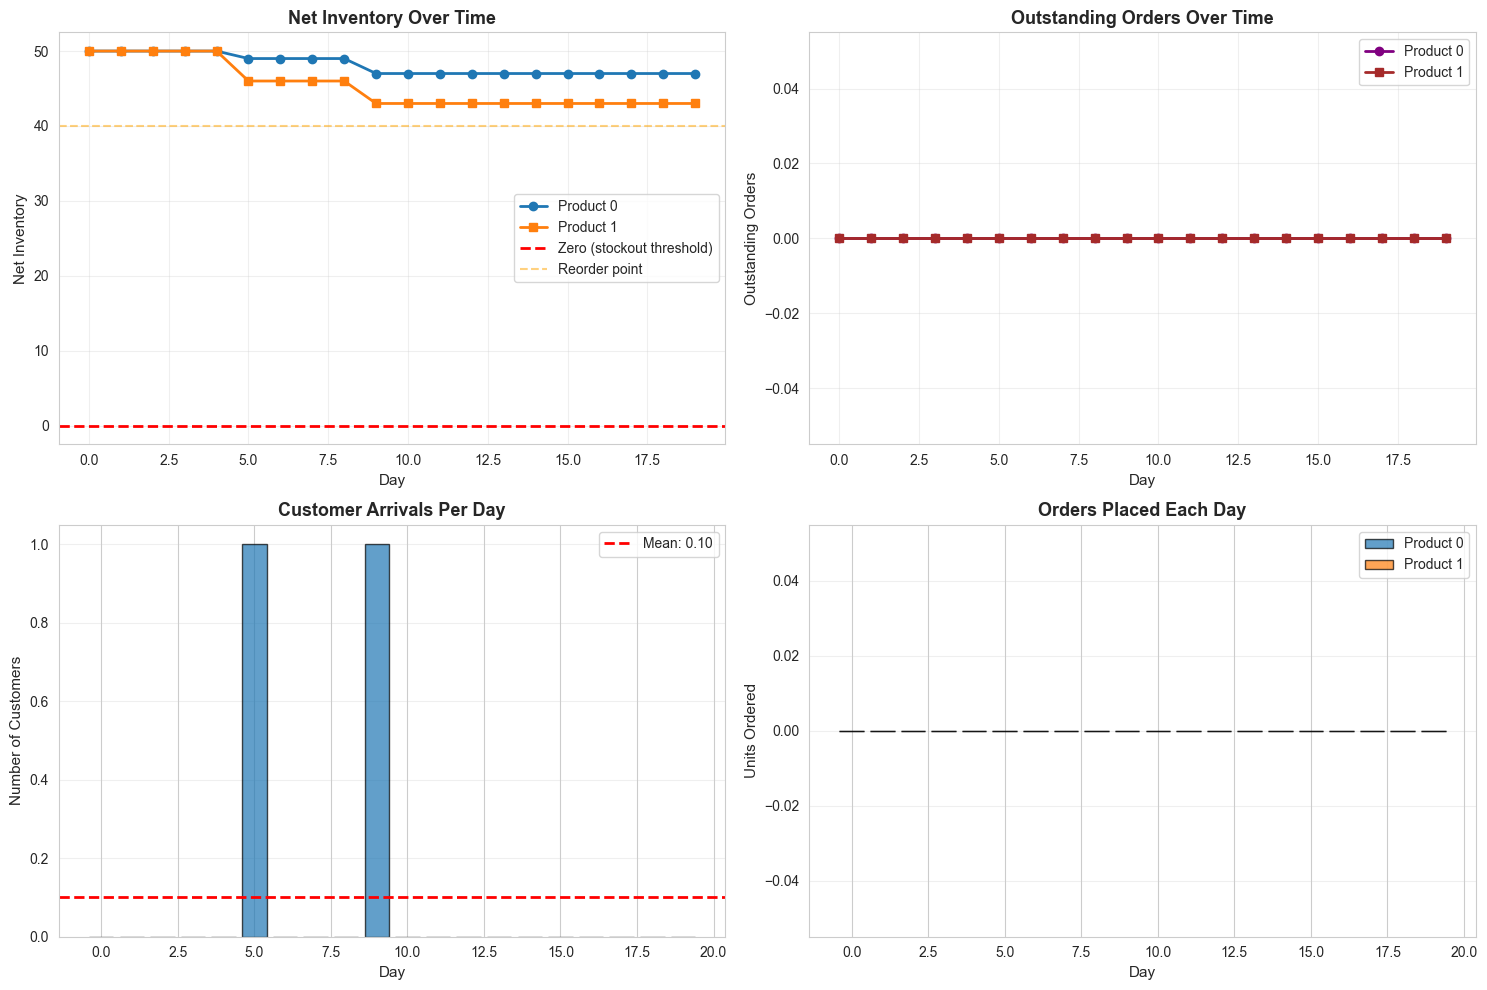


✓ Key observations:
   - Net inventory fluctuates due to stochastic demand
   - Policy orders when inventory position drops below 40
   - Outstanding orders show orders in-transit
   - Customer arrivals are random (exponential)


In [6]:
# Extract data
days = [h['day'] for h in history]
net_inv_0 = [h['net_inv_0'] for h in history]
net_inv_1 = [h['net_inv_1'] for h in history]
outstanding_0 = [h['outstanding_0'] for h in history]
outstanding_1 = [h['outstanding_1'] for h in history]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Net inventory
axes[0, 0].plot(days, net_inv_0, marker='o', linewidth=2, label='Product 0')
axes[0, 0].plot(days, net_inv_1, marker='s', linewidth=2, label='Product 1')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero (stockout threshold)')
axes[0, 0].axhline(40, color='orange', linestyle='--', alpha=0.5, label='Reorder point')
axes[0, 0].set_xlabel('Day', fontsize=11)
axes[0, 0].set_ylabel('Net Inventory', fontsize=11)
axes[0, 0].set_title('Net Inventory Over Time', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Outstanding orders
axes[0, 1].plot(days, outstanding_0, marker='o', linewidth=2, label='Product 0', color='purple')
axes[0, 1].plot(days, outstanding_1, marker='s', linewidth=2, label='Product 1', color='brown')
axes[0, 1].set_xlabel('Day', fontsize=11)
axes[0, 1].set_ylabel('Outstanding Orders', fontsize=11)
axes[0, 1].set_title('Outstanding Orders Over Time', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Daily customers
customers = [h['customers'] for h in history]
axes[1, 0].bar(days, customers, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(np.mean(customers), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(customers):.2f}')
axes[1, 0].set_xlabel('Day', fontsize=11)
axes[1, 0].set_ylabel('Number of Customers', fontsize=11)
axes[1, 0].set_title('Customer Arrivals Per Day', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Orders placed
ordered_0 = [h['ordered_0'] for h in history]
ordered_1 = [h['ordered_1'] for h in history]
axes[1, 1].bar(days, ordered_0, alpha=0.7, label='Product 0', edgecolor='black')
axes[1, 1].bar(days, ordered_1, alpha=0.7, label='Product 1', bottom=ordered_0, edgecolor='black')
axes[1, 1].set_xlabel('Day', fontsize=11)
axes[1, 1].set_ylabel('Units Ordered', fontsize=11)
axes[1, 1].set_title('Orders Placed Each Day', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Key observations:")
print("   - Net inventory fluctuates due to stochastic demand")
print("   - Policy orders when inventory position drops below 40")
print("   - Outstanding orders show orders in-transit")
print("   - Customer arrivals are random (exponential)")

## Part 4: What Happens During Stockout?

In [7]:
# Start with low inventory - force stockout
sim = InventorySimulation(params, np.random.default_rng(456))
sim.reset(create_observation(5, 5, 0, 0))  # Low initial inventory!

print("Forcing stockout scenario...\n")
print("Starting with low inventory: (5, 5)")

stockout_history = []
current_obs = create_observation(5, 5, 0, 0)

for day in range(10):
    # No ordering policy (to force stockout)
    action = order_both_products(0, 0)  # Don't order!
    
    next_obs, info = sim.execute_daily_decision(action)
    
    stockout_history.append({
        'day': day,
        'net_inv_0': next_obs.net_inventory[0],
        'net_inv_1': next_obs.net_inventory[1],
        'on_hand_0': next_obs.get_on_hand_inventory(0),
        'on_hand_1': next_obs.get_on_hand_inventory(1),
        'backorders_0': next_obs.get_backorders(0),
        'backorders_1': next_obs.get_backorders(1),
        'customers': info['num_customers'],
    })
    
    # Print when stockout occurs
    if next_obs.net_inventory[0] < 0 or next_obs.net_inventory[1] < 0:
        print(f"Day {day}: STOCKOUT! Net inv = {next_obs.net_inventory}")
        print(f"  → Backorders: ({next_obs.get_backorders(0)}, {next_obs.get_backorders(1)})")
    
    current_obs = next_obs

Forcing stockout scenario...

Starting with low inventory: (5, 5)
Day 9: STOCKOUT! Net inv = (np.int64(-1), np.int64(-5))
  → Backorders: (1, 5)


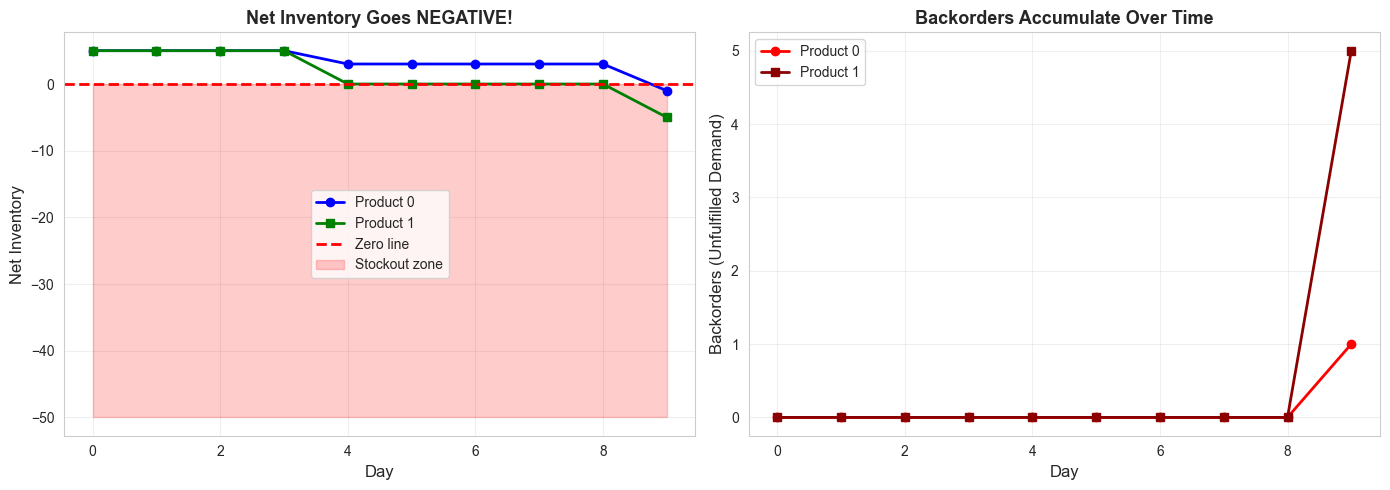


💡 Key insight: Net inventory going negative = backorders!
   Final net inventory: (-1, -5)
   Final backorders: (1, 5)
   These cost π=$7.0 per unit per day!


In [8]:
from src.mdp import CostParameters

# Visualize stockout evolution
days = [h['day'] for h in stockout_history]
net_inv_0 = [h['net_inv_0'] for h in stockout_history]
net_inv_1 = [h['net_inv_1'] for h in stockout_history]
backorders_0 = [h['backorders_0'] for h in stockout_history]
backorders_1 = [h['backorders_1'] for h in stockout_history]

pi = CostParameters.pi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Net inventory (can go negative!)
axes[0].plot(days, net_inv_0, marker='o', linewidth=2, label='Product 0', color='blue')
axes[0].plot(days, net_inv_1, marker='s', linewidth=2, label='Product 1', color='green')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[0].fill_between(days, -50, 0, alpha=0.2, color='red', label='Stockout zone')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Net Inventory', fontsize=12)
axes[0].set_title('Net Inventory Goes NEGATIVE!', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Backorders accumulate
axes[1].plot(days, backorders_0, marker='o', linewidth=2, label='Product 0', color='red')
axes[1].plot(days, backorders_1, marker='s', linewidth=2, label='Product 1', color='darkred')
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Backorders (Unfulfilled Demand)', fontsize=12)
axes[1].set_title('Backorders Accumulate Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key insight: Net inventory going negative = backorders!")
print(f"   Final net inventory: ({net_inv_0[-1]}, {net_inv_1[-1]})")
print(f"   Final backorders: ({backorders_0[-1]}, {backorders_1[-1]})")
print(f"   These cost π=${pi} per unit per day!")

## 🎯 Summary

**What you learned:**

1. **Stochastic System**:
   - Customers arrive randomly (exponential)
   - Demand is random per customer
   - Lead times are random (uniform)

2. **Net Inventory Dynamics**:
   - Decreases when demand arrives
   - Increases when orders arrive
   - **Can go negative** → backorders

3. **Outstanding Orders**:
   - Increase when we place orders
   - Decrease when orders arrive
   - Track in-transit inventory

4. **Stockouts Are Bad**:
   - Net inventory < 0 = customers waiting
   - Backorders accumulate if not careful
   - Very expensive (π=7 vs h=1)

5. **SimPy Under the Hood**:
   - Uses process-based discrete event simulation
   - Customer arrivals = continuous process
   - Order arrivals = one-shot processes
   - You don't need to know SimPy details - the interface is simple!

**Next**: Implement baseline (s,S) policy to manage inventory